In [41]:
import os, glob, json
import pandas as pd
import matplotlib.pyplot as plt

log_files = glob.glob("pilotTest/game_*agents_run*_*.json")


In [42]:
# Cell 2 — Parse each JSON into a flat table of per-run metrics
records = []
for path in log_files:
    data = json.load(open(path))
    meta = data["metadata"]
    # extract agent count and replicate from filename
    # e.g. "game_4agents_run1_20250801_103431.json"
    parts = os.path.basename(path).split("_")
    n_agents = int(parts[1].replace("agents",""))
    run_idx  = int(parts[2].replace("run",""))
    
    # Win flag
    werewolf_win = int(data["winner"] == "werewolves")
    
    # Days survived: if werewolf loses, find the day they were lynched;
    # otherwise take max day in events
    if werewolf_win:
        days_survived = max(evt["day"] for evt in data["events"] if "day" in evt)
    else:
        # find first elimination of the werewolf
        for evt in data["events"]:
            if evt["event_type"]=="elimination" and evt.get("target") in meta["roles"] \
               and meta["roles"][evt["target"]] == "werewolf":
                days_survived = evt["day"]
                break
        else:
            days_survived = 0

    # Count how many votes the werewolf received across all 'vote' events
    w_id = next(k for k,v in meta["roles"].items() if v=="werewolf")
    votes_received = 0
    for evt in data["events"]:
        if evt["event_type"]=="vote":
            # votes is a dict: voter→votee
            votes_received += sum(1 for votee in evt["votes"].values() if votee==w_id.replace("Agent","Agent"))
    records.append({
        "n_agents": n_agents,
        "run": run_idx,
        "werewolf_win": werewolf_win,
        "days_survived": days_survived,
        "votes_received": votes_received
    })

df = pd.DataFrame(records)
df.head()


,n_agents,run,werewolf_win,days_survived,votes_received
0,5,1,1,3,2
1,9,4,0,2,6
2,6,5,1,4,4
3,7,5,1,4,1
4,4,4,1,2,1


In [43]:
print(df)

    n_agents  run  werewolf_win  days_survived  votes_received
0          5    1             1              3               2
1          9    4             0              2               6
2          6    5             1              4               4
3          7    5             1              4               1
4          4    4             1              2               1
5          8    3             0              6               3
6          5    4             0              2               2
7          3    4             1              1               1
8          8    1             0              4               7
9          4    6             1              2               2
10         7    4             1              4               1
11         5    5             1              3               1
12         3    2             1              1               1
13         6    2             0              5               3
14         4    3             1              2         

In [45]:
# Cell 3 — Compute per-condition summaries (including number of games)
summary = (
    df
    .groupby("n_agents")
    .agg(
        num_games       = ("werewolf_win",   "count"),
        win_rate        = ("werewolf_win",   "mean"),
        mean_survival   = ("days_survived",  "mean"),
        mean_votes_recv = ("votes_received", "mean")
    )
    .reset_index()
)
summary


,n_agents,num_games,win_rate,mean_survival,mean_votes_recv
0,3,6,1.000000,1.000000,1.000000
1,4,6,1.000000,2.000000,1.500000
2,5,6,0.333333,2.333333,2.000000
3,6,5,0.600000,3.600000,2.200000
4,7,6,1.000000,3.833333,1.500000
5,8,6,0.166667,4.166667,5.000000
6,9,6,0.333333,3.333333,4.333333


### Plotting x-axis (# of agents) vs y-axis metrics

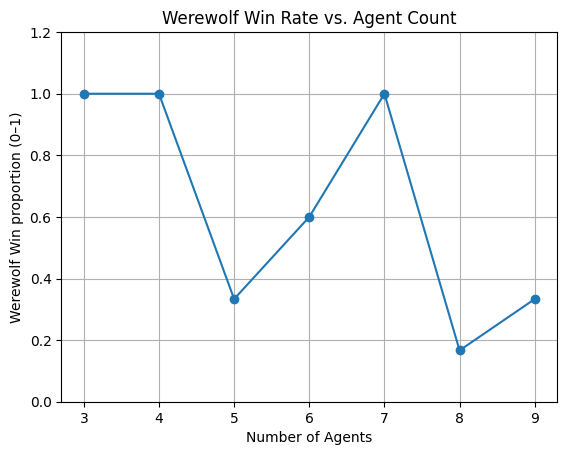

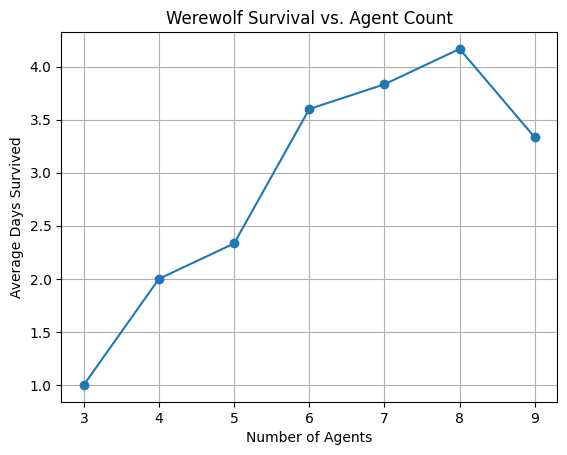

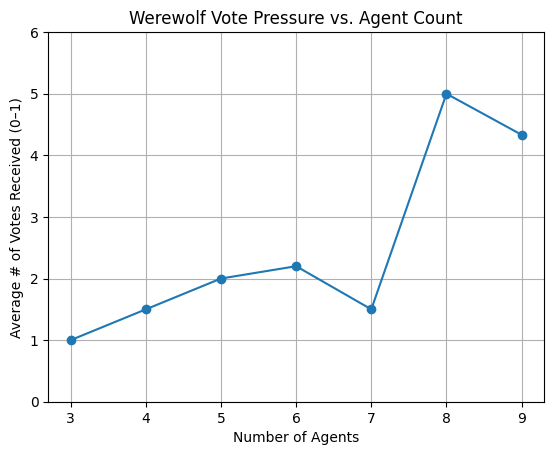

In [46]:
# 1) Win rate (0–1 scale)
plt.figure()
plt.plot(summary["n_agents"], summary["win_rate"], marker='o')
plt.ylim(0, 1.2)
plt.xlabel("Number of Agents")
plt.ylabel("Werewolf Win proportion (0–1)")
plt.title("Werewolf Win Rate vs. Agent Count")
plt.grid(True)

# 2) Mean survival days
plt.figure()
plt.plot(summary["n_agents"], summary["mean_survival"], marker='o')
plt.xlabel("Number of Agents")
plt.ylabel("Average Days Survived")
plt.title("Werewolf Survival vs. Agent Count")
plt.grid(True)

# 3) Mean votes received (treated as a proportion out of alive players, 0–1)
plt.figure()
plt.plot(summary["n_agents"], summary["mean_votes_recv"], marker='o')
plt.ylim(0, 6)
plt.xlabel("Number of Agents")
plt.ylabel("Average # of Votes Received (0–1)")
plt.title("Werewolf Vote Pressure vs. Agent Count")
plt.grid(True)

plt.show()
